# Explanation with SHAP

Aim of this notebook:

In this notebook we consider a subset of the SwedishMotorInsurance dataset and the claim amount per exposure as target variable. We build a simple DecisionTreeRegressor with deepness 2 and explain the prediction of it on a single dataset with the help of the "shap" package. A further aim of this notebook is to implement ourself the shapley values and to compare them with the shapley values of the package.

## Importing packages

In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

## read data and data preparation

In [2]:
# reading the data:
df = pd.read_csv('../0_Datasets/Regression/SwedishMotorInsurance.csv', 
                 dtype={'Kilometres':'category',
                        'Zone':'category',
                        'Bonus':'category',
                        'Make':'category'})

# select datasets with claims:
df = df[df['Claims'] > 0]
df.reset_index(inplace=True)

# calculate height of claims per exposure and log transformation:
df['claims requirement'] = df['Payment'] / df['Insured'] 
df['log claims requirement'] = np.log(df['claims requirement']) # TARGET

# build design matrix and target vector:
liste_cat = ['Kilometres', 'Zone', 'Bonus', 'Make']
target = 'claims requirement'
target_log = 'log ' + target
X = df[liste_cat]
y = df[target_log]

count    1797.000000
mean        5.561753
std         0.961000
min         2.135442
25%         4.990482
50%         5.551581
75%         6.148060
max         9.443617
Name: log claims requirement, dtype: float64


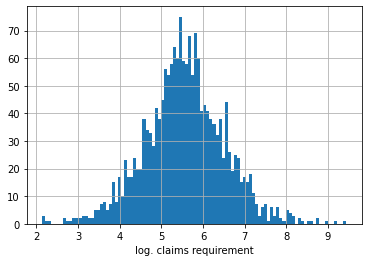

In [3]:
# exploratory data analysis:

# histogram for claims and logarithmed claims:
df[target_log].hist(bins=100)
plt.rcParams.update({'font.size': 12});
plt.xlabel('log. claims requirement')
print(df[target_log].describe())

# Modelling

In [4]:
# Modelling (DecisionTreeRegressor):

DT = DecisionTreeRegressor(random_state=42, max_depth=2)
DT.fit(X, y)

# Prediction:
y_predict_DT = DT.predict(X)

print('Mean y_predict:', y_predict_DT.mean())
print('Observed mean:', y.mean())

Mean y_predict: 5.561752692685165
Observed mean: 5.561752692685166


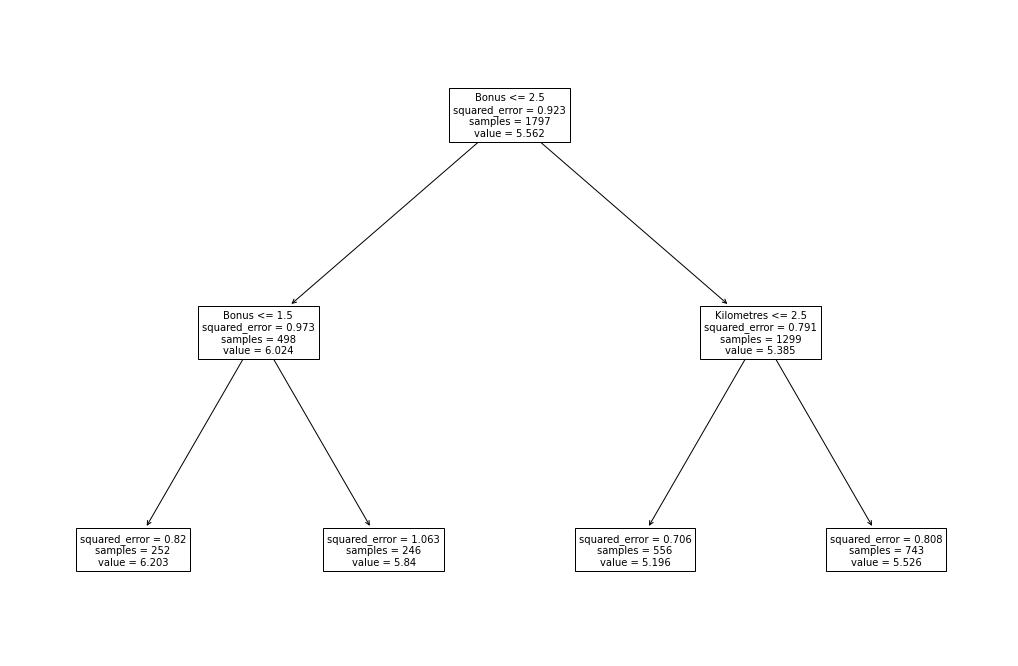

In [5]:
# plot tree:
from sklearn import tree
plt.figure(figsize=(18,12))
tree.plot_tree(DT, fontsize=10, feature_names=X.columns)
plt.show()

## SHAP package and shapley Values:

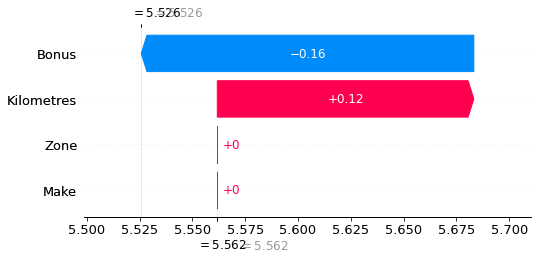

In [6]:
def plot_waterfall(X, index_ID, TREE_model):
    """waterfall plot with SHAP for fixed instance with index 'index_ID'"""
        
    explainer = shap.TreeExplainer(TREE_model)
    shap_values = explainer.shap_values(X)

    row_nr = np.where(X.index==index_ID)[0]

    shap.initjs()

    # shap waterfall:
    # Documentation: https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html
    try:
        waterfall = shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[row_nr][0],
                                                           feature_names=X.columns, show=False,
                                                           max_display=10)
    except:
        waterfall = shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[row_nr][0],
                                                           feature_names=X.columns, show=False,
                                                           max_display=10)        

# choice of a single data set:
data_ID_of_interest = 797
explainer = shap.TreeExplainer(DT, algorithm='tree')
plot_waterfall(X, data_ID_of_interest, DT)

**Own implementation of shapley values:**

The $\textbf{formula}$ of the $\textbf{shapley values}$ is given by (see section 9.5.3.1 of https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value-in-detail):

$\phi_j(val_x) = \underset{S\subseteq \{F_{1}, \ldots, F_{p}\}\setminus\{F_{j}\}}{\sum}\frac{|S|! (p - |S| - 1)!}{p!} \cdot \underbrace{\left(val_x(S\,\cup\,\{F_{j}\}) - val_x(S)\right)}_{=: mc(x,F_{j},S)}$.

Here $x$ is the dataset of interest and $j$ the number of feature $F_{j}$ for which we want to compute the shapley value. $\{F_{1}, \ldots, F_{p}\}$ is the set of features in the model. $mc(x,F_{j},S)$ is the $\textbf{marginal contribution}$ and is roughly speaking the change of the prediction if we add the concrete information of feature $j$ to the set $S$.

The marginal contribution $mc(x,F_{j},S)$ on a set $S$ of features is estimated by a Monte-Carlo simulation (see section 9.5.3.3 of Molnar) via

$mc(x,F_{j},S) \approx \frac{1}{M}\underset{m\,=\,1}{\overset{M}{\sum}} \left(\hat{f}(x_{+}^{m}) - \hat{f}(x_{-}^{m})\right)$.

For the calculation in the $m$-th step we choose a random instance $z$ of our data set. For building $x_{-}$ we replace z with all concrete values of our instance of interest $x$ in the features of fixed set $S$, all other features keep the values of $z$. For $x_{+}$ we replace the value of feature $j$ in $x_{-}$ by the concrete value of feature $j$ in x. We repeat this $M$ times to get an approximation.

In [7]:
def compute_marginal_contribution(data, data_ID_of_interest, model, S, set_shap_feature, features_of_model,
                                  M=1000, verbose=False):
    """approach by Molnar"""
    
    # data of interest (to explain)
    instance = data.loc[[data_ID_of_interest]]
    
    # create M random instances from dataset:
    rand_int = np.random.randint(0, X.shape[0], size=M)
    z = data.iloc[rand_int]
    
    # create x_minus:
    x_minus = z.copy() # for instance without shap feature
    for level in list(S):
        x_minus[level] = instance[level].values[0]
    
    # create x_plus:
    x_plus = x_minus.copy() # for instance with shap feature
    x_plus[list(set_shap_feature)] = instance[list(set_shap_feature)].values[0]
    mc = model.predict(x_plus) - model.predict(x_minus)  ## this works only for sklearn regression models, for classifcation model.predict yields the majority vote, here you would use model.predict_proba
    result = mc.mean()
    
    # print, if verbose=True:
    if verbose:
        print('random instance = \n', z)
        print('x_minus = \n', x_minus)
        print('x_plus = \n', x_plus)
        print('result', result)
    return result

def shapley_values(data, data_ID_of_interest, shap_feature, features_of_model, model, variant=1, verbose=False):
    """calculates shapley values"""
    from math import factorial as fac
    assert(data_ID_of_interest in data.index)
    
    shap_val = 0 # initialization of output
    p = len(features_of_model) # number of features in model
    if shap_feature not in features_of_model: return shap_val
    
    # build powerset:
    from more_itertools import powerset
    set_shap_feature = set([shap_feature])
    lofwsf = set(features_of_model).difference(set_shap_feature)# list of features of model without shap feature
    if verbose: print('Given shap feature: ', shap_feature)
    powerset_list = list(powerset(lofwsf))
    if verbose: print('Liste Potenzmenge:', powerset_list)
    
    # iteration over sets of powerset:
    for S in powerset_list:
        # compute weights (cp. formula):
        weight = ( fac(len(S)) * fac(p - len(S) - 1) ) / ( fac(p) )
        
        # compute marginal contribution (approximation as described above):
        mc = compute_marginal_contribution(data, data_ID_of_interest, model, list(S), list(set_shap_feature),
                                               features_of_model, M=10000, verbose=False)
        if verbose: print(list(S))
        if verbose: print(mc)
        if verbose: print(mc*weight)
        shap_val += weight*mc
    return shap_val

In [8]:
# data set of interest:
X.loc[data_ID_of_interest]

Kilometres    3
Zone          1
Bonus         3
Make          1
Name: 797, dtype: object

**concrete example for m-th step in Monte Carlo simulation:**

In [9]:
S = ['Kilometres']
shap_feature = ['Bonus']

print('S = ', S)
print('Feature of interest:', shap_feature[0])

print('\n')

print('Instance of interest (index=797):')
instance = X.loc[[797]]
print(instance)

print('\n')

print('Random instance (e.g. index=194):')
index = 194
z = X.loc[[index]]
print(z)

x_minus = z.copy() # for instance without shap feature
for level in list(S):
    x_minus[level] = instance[level].values[0]
x_plus = x_minus.copy() # for instance with shap feature
x_plus[list(shap_feature)] = instance[list(shap_feature)].values[0]

print('\n')

print('x_minus:')
print(x_minus)

print('\n')

print('x_plus:')
print(x_plus)

print('\n')

print('Prediction of x_plus:')
print(DT.predict(x_plus))
print('Prediction of x_minus:')
print(DT.predict(x_minus))

print('marginal contribution:')
print(DT.predict(x_plus) - DT.predict(x_minus))


S =  ['Kilometres']
Feature of interest: Bonus


Instance of interest (index=797):
    Kilometres Zone Bonus Make
797          3    1     3    1


Random instance (e.g. index=194):
    Kilometres Zone Bonus Make
194          1    4     2    2


x_minus:
    Kilometres Zone Bonus Make
194          3    4     2    2


x_plus:
    Kilometres Zone Bonus Make
194          3    4     3    2


Prediction of x_plus:
[5.52570936]
Prediction of x_minus:
[5.84011094]
marginal contribution:
[-0.31440159]


**concrete example for Monte Carlo simulation with $M=10$ and $S=\{Kilometres\}$ for calculating shapley value of feature 'Kilometres':**

In [10]:
# Example for calculationg marginal contribution with simulation
features_of_model = ['Kilometres', 'Bonus', 'Zone', 'Make']
S = ['Kilometres']
shap_feature = ['Bonus']

compute_marginal_contribution(X, data_ID_of_interest, DT, S, shap_feature, features_of_model,
                                  M=10, verbose=True)

random instance = 
      Kilometres Zone Bonus Make
1292          4    3     3    6
724           2    6     5    2
1341          4    4     3    2
760           2    7     3    6
1429          4    6     2    5
1703          5    4     7    7
303           1    6     1    5
1670          5    4     3    8
1291          4    3     3    5
1224          4    2     2    2
x_minus = 
      Kilometres Zone Bonus Make
1292          3    3     3    6
724           3    6     5    2
1341          3    4     3    2
760           3    7     3    6
1429          3    6     2    5
1703          3    4     7    7
303           3    6     1    5
1670          3    4     3    8
1291          3    3     3    5
1224          3    2     2    2
x_plus = 
      Kilometres Zone Bonus Make
1292          3    3     3    6
724           3    6     3    2
1341          3    4     3    2
760           3    7     3    6
1429          3    6     3    5
1703          3    4     3    7
303           3    6     3   

-0.13060505544253492

**Calculation of shapley values with own implementation:**

In [25]:
data_ID_of_interest = 797
features_of_model = ['Kilometres', 'Bonus', 'Zone', 'Make']
shap_kilometres = shapley_values(X, data_ID_of_interest, 'Kilometres', features_of_model, DT,
                                 verbose=False)
shap_zone = shapley_values(X, data_ID_of_interest, 'Zone', features_of_model, DT)
shap_bonus = shapley_values(X, data_ID_of_interest, 'Bonus', features_of_model, DT)
shap_make = shapley_values(X, data_ID_of_interest, 'Make', features_of_model, DT)

print('Shapley value Kilometres:', shap_kilometres)
print('Shapley value Zone:', shap_zone)
print('Shapley value Bonus:', shap_bonus)
print('Shapley value Make:', shap_make)

# Checks:
sum_shap_values = shap_kilometres +  shap_zone + shap_bonus + shap_make
print('Sum of Shapley values:', sum_shap_values)
consistency = DT.predict(X).mean() + sum_shap_values - DT.predict(X.loc[[data_ID_of_interest]])
print('Consistency check:', list(map('{:.6e}'.format, consistency))[0])

Shapley value Kilometres: 0.12271152971056618
Shapley value Zone: 0.0
Shapley value Bonus: -0.15929386112180444
Shapley value Make: 0.0
Sum of Shapley values: -0.03658233141123826
Consistency check: -5.389962e-04


**Comparison with shapley values of package SHAP:**

In [12]:
explainer = shap.TreeExplainer(DT, algorithm='auto')
row_nr = np.where(X.index==data_ID_of_interest)[0]
shap_values = explainer.shap_values(X.iloc[row_nr])[0]

In [13]:
shap_values_df = pd.DataFrame(data={'shap_values': shap_values},
                              index=X.iloc[row_nr].columns)
print(shap_values_df)
print('sum of SHAP values:', shap_values_df.sum())

            shap_values
Kilometres     0.121516
Zone           0.000000
Bonus         -0.157559
Make           0.000000
sum of SHAP values: shap_values   -0.036043
dtype: float64
